In [44]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import imutils
import imutils.perspective as persp
import skimage.filters as filters
import scipy.spatial.distance as dist
import cv2
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin

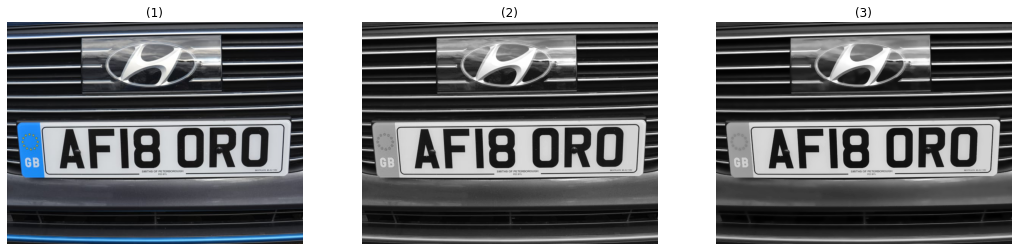

In [84]:
imagesFirst=[]

#reading the car image
car=io.imread('images/pic1.jpg')
imagesFirst.append(car)

#converting image into gray scale
grayCar=cv2.cvtColor(car,cv2.COLOR_BGR2GRAY)
imagesFirst.append(grayCar)

#applying median for reducing noise
car_denoised=cv2.bilateralFilter(grayCar,11,17,17)
imagesFirst.append(car_denoised)


show_images(imagesFirst)

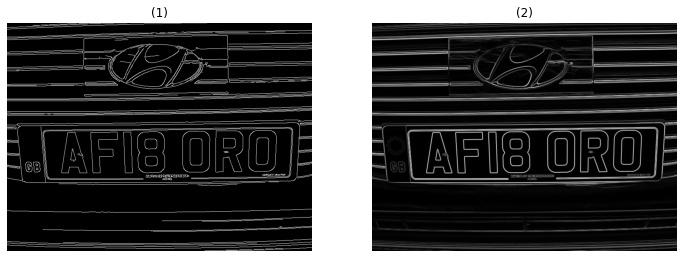

In [85]:


imagesSecond=[]
#using Canny edge detector
edges=cv2.Canny(car_denoised, 100,250)
# edgesG=filters.gaussian(edges, sigma = 0.8)


# footPrint=[[0,1,0],[1,1,1],[0,1,0]]
# edgesN=binary_dilation(edges,footPrint)
sobelImg=sobel(car_denoised)

imagesSecond.append(edges)
imagesSecond.append(sobelImg)
# imagesSecond.append(edgesG)
# imagesSecond.append(edgesN)


show_images(imagesSecond)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


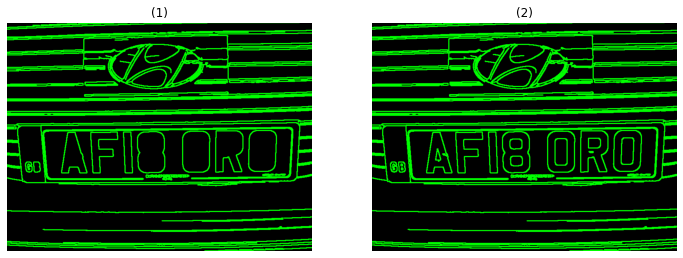

In [86]:
imagesC=[]

keypoints = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#chnage to RETR_TREE fro chars details to be detected
keypointsD = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contourss=imutils.grab_contours(keypoints)
contourssD=imutils.grab_contours(keypointsD)

black_images=np.zeros(car.shape)
black_imagesD=np.zeros(car.shape)


cv2.drawContours(black_images,contourss,-1,(0,255,0),2)
cv2.drawContours(black_imagesD,contourssD,-1,(0,255,0),2)

#print(contourss)
#to sort and get biggest 10 contours
contours=sorted(contourss,key=cv2.contourArea,reverse=True)[:10]

#len(contours)
show_images([black_images,black_imagesD])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


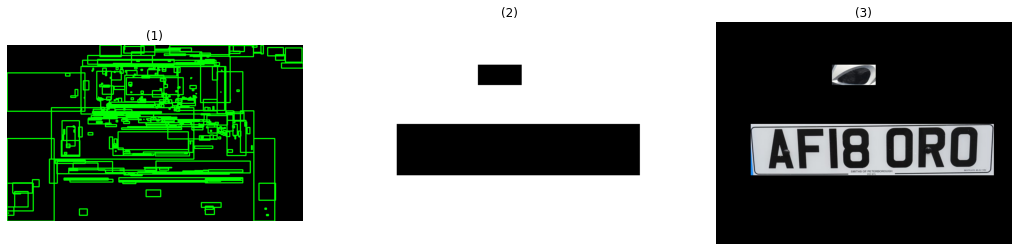

In [87]:
blackImg=np.zeros(car.shape)
for contour in contourss:
    (x,y,w,h) = cv2.boundingRect(contour)
    cv2.rectangle(blackImg, (x,y), (x+w,y+h), (0,255,0), 2)


#loop over all the contour coordinates
mask = np.ones(car.shape[:2], dtype="uint8") * 255
for c in contours:
    # get the bounding rect
    # x,y is the min points of rect & w"width"/h"height"
    x, y, w, h = cv2.boundingRect(c)
    if w*h>1000:#filtering if the rectangel area is above 1000
        cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 0, 255), -1)#drawing the rectangle

res_final = cv2.bitwise_and(car, car, mask=cv2.bitwise_not(mask))


show_images([blacck,mask,res_final])

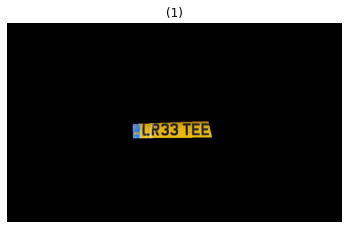

In [41]:
mask=np.zeros(grayCar.shape,np.uint8)
new_image=cv2.drawContours(mask,[location],-1,255,-1)
new_image=cv2.bitwise_and(car,car,mask=mask)

show_images([new_image])

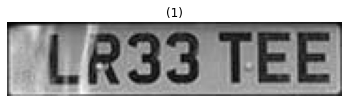

In [42]:
(x,y)=np.where(mask==255)
(x1,y1)=(np.min(x),np.min(y))
(x2,y2)=(np.max(x),np.max(y))
cropped_image=grayCar[x1:x2+1,y1:y2+1]
show_images([cropped_image])